In [2]:
### dimension reduce & cluster with UMAP

import umap
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from io import BytesIO
from PIL import Image
import base64

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper

2024-04-22 07:40:05.030097: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 07:40:05.030151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 07:40:05.031113: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-22 07:40:05.036927: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 07:40:05.723356: W tensorflow/compiler/tf2

In [3]:
## import features and charter listf

array_path = r"/home/tschernn/clustering/img_array.pkl"

with open(array_path, 'rb') as file:
    img_array = pickle.load(file)

feature_path = r"/home/tschernn/clustering/features_hog.pkl"

with open(feature_path, 'rb') as file:
    data = pickle.load(file)

charter_path = r"/home/tschernn/clustering/charter_list.pkl"

with open(charter_path, 'rb') as file:
    charters = pickle.load(file)

data.shape

(155, 155)

In [3]:
img_vectors = [img.flatten() for img in img_array]
img_vectors = np.array(img_vectors)
img_vectors.shape

(155, 1000000)

In [4]:
## fit and transform

reducer = umap.UMAP()
embedding = reducer.fit_transform(data)

# UMAP by default reduces to 2D
embedding.shape

(155, 2)

In [5]:
reducer = umap.UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)
reducer.fit(data.data)

embedding = reducer.transform(data.data)

/home/tschernn/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


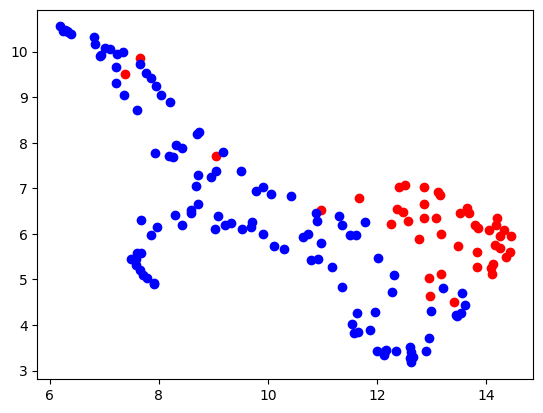

In [6]:
## plot data

label_color_map = {
    'writable_area_notar': 'red',
    'writable_area_papst_oe': 'blue'
}

for point, charter in zip(embedding, charters):
    x,y = point
    label = charter[1]
    color = label_color_map[label]
    plt.scatter(x, y, c=color)

In [7]:
### export data as pickle file
feature_path = feature_path.split('.')[0]
feature_path = feature_path + '_dimred.pkl'

with open(feature_path,'wb') as file:
    pickle.dump(embedding, file)
    print(f'Saved features as {file.name}.')

Saved features as /home/tschernn/clustering/features_hog_dimred.pkl.


In [8]:
### bokeh implementation adapted from https://umap-learn.readthedocs.io/en/latest/basic_usage.html

def embeddable_image(data):
    img_data = 255 - 15 * data.astype(np.uint8)
    image = Image.fromarray(img_data, mode='L').resize((256, 256), Image.Resampling.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()


## draw plot

output_notebook()

charters_df = pd.DataFrame(embedding, columns=('x', 'y'))
charters_df['class'] = [x[1] for x in charters]
charters_df['image'] = list(map(embeddable_image, img_array))
charters_df['name'] = [x[0] for x in charters]

datasource = ColumnDataSource(charters_df)
color_mapping = CategoricalColorMapper(factors=['writable_area_notar', 'writable_area_papst_oe'],
                                       palette=["red", "blue"])

plot_figure = figure(
    title='UMAP projection of the charters',
    width=600,
    height=600,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>Charter:</span>
        <span style='font-size: 18px'>@name</span>
    </div>
</div>
"""))

plot_figure.scatter(
    'x',
    'y',
    source=datasource,
    color=dict(field='class', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=4
)
show(plot_figure)

Loading BokehJS ...